# Simple AE

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import regularizers
#simple autoencoder
def encoder(input,encoding_dim):
  ## encoding part
  encoded = Dense(2000, activation='tanh')(input)
  encoded = Dense(1000, activation='relu')(encoded)
  encoded = Dense(encoding_dim, activation = 'relu')(encoded)
  return encoded
def decoder(encoded):
  ## decoding part
  decoded = Dense(1000, activation='tanh')(encoded)
  decoded = Dense(2000, activation='tanh')(decoded)
  return decoded
def AE_model(Train_X,encode_dim):
  input_layer = Input(shape=(Train_X.shape[1],))
  x = encoder(input_layer,encode_dim)
  x_hat = decoder(x)
  ## output layer
  output_layer = Dense(Train_X.shape[1], activation='relu')(x_hat)
  model = Model(input_layer, output_layer)
  method_enconder = Model(input_layer, x, name="encoder")
  return model,method_enconder
def AE_hiddenrepresentation(data,method_enconder):
        """Transform the vector.
        From original dimensions to latent dimensions.
        Parameters
        ----------
        data : array-like  (n_samples, n_features)
            The input data to use in transform process.
        Returns
        -------
        _ : array-like  (n_samples, value_encoding_dim)
            The data transformed to latent dimensions format.
        """
        return method_enconder.predict(data)
def extractrep(model):
  hidden_representation = Sequential()
  hidden_representation.add(model.layers[0])
  hidden_representation.add(model.layers[1])
  hidden_representation.add(model.layers[2])
  hidden_representation.add(model.layers[3])
  return hidden_representation

# loading and preprocessing

In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
from sklearn import svm
from tensorflow import keras
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import History
from google.colab import files
from sklearn.metrics import confusion_matrix
import re
from imblearn.under_sampling import ClusterCentroids
sns.set(style="whitegrid")
np.random.seed(203)
encodding_dim= 700
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(info_test,info_train,info_dev):
  local_path='/content/drive/My Drive/.../down sampled 3'
  Train_MList = []
  Test_MList = []
  Dev_MList = []
  Train_FList = []
  Test_FList = []
  Dev_FList = []
  for filename in os.listdir(local_path):
    if filename.endswith('.csv'): 
        file_path=local_path+'/'+filename
        File = pd.read_csv(file_path)
        nameid= re.sub('\.csv$', '',  filename)
        nameid=int(nameid)
        if info_train[info_train['Participant_ID']==nameid].index.tolist():
          listindex=info_train[info_train['Participant_ID']==nameid].index.tolist()
          temp = info_train.iloc[listindex]
          index = list(temp.index)
          gender = temp.loc[index[0], 'Gender']
          label = temp.loc[index[0], 'PHQ8_Binary']
          File = File.assign(Class=label)
          if gender==1 :#if male 
            Train_MList.append(File)
          else: #female
            Train_FList.append(File)
        if info_test[info_test['Participant_ID']==nameid].index.tolist():
          listindex=info_test[info_test['Participant_ID']==nameid].index.tolist()
          temp = info_test.iloc[listindex]
          index = list(temp.index)
          gender = temp.loc[index[0], 'Gender']
          label = temp.loc[index[0], 'PHQ_Binary']
          File = File.assign(Class=label)
          if gender==1 :#if male 
            Test_MList.append(File)
          else: #female
            Test_FList.append(File) 
        if info_dev[info_dev['Participant_ID']==nameid].index.tolist():
          listindex=info_dev[info_dev['Participant_ID']==nameid].index.tolist()
          temp = info_dev.iloc[listindex]
          index = list(temp.index)
          gender = temp.loc[index[0], 'Gender']
          label = temp.loc[index[0], 'PHQ8_Binary']
          File = File.assign(Class=label)
          if gender==1 :#if male 
            Dev_MList.append(File)
          else: #female
            Dev_FList.append(File) 
  new_Train_F = pd.concat(Train_FList)
  new_Test_F = pd.concat(Test_FList)
  new_Dev_F = pd.concat(Dev_FList)    
  new_Train_M = pd.concat(Train_MList)
  new_Test_M = pd.concat(Test_MList)
  new_Dev_M = pd.concat(Dev_MList)  
  return new_Train_F,new_Test_F,new_Dev_F,new_Train_M,new_Test_M,new_Dev_M

def clusterin_resampling (Train_F,Test_F,Dev_F,Train_M,Test_M,Dev_M):
  colnames=list(Train_F.columns)
  x = Train_F.drop(["Class"], axis=1)
  y = Train_F["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_train=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_train_F = pd.DataFrame(data = wholedata_train,columns = colnames) 

  x = Dev_F.drop(["Class"], axis=1)
  y = Dev_F["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_dev=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_dev_F = pd.DataFrame(data = wholedata_dev,columns = colnames) 

  x = Test_F.drop(["Class"], axis=1)
  y = Test_F["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_test=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_test_F = pd.DataFrame(data = wholedata_test,columns = colnames) 
 
  x = Train_M.drop(["Class"], axis=1)
  y = Train_M["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_train=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_train_M = pd.DataFrame(data = wholedata_train,columns = colnames) 

  x = Dev_M.drop(["Class"], axis=1)
  y = Dev_M["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_dev=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_dev_M = pd.DataFrame(data = wholedata_dev,columns = colnames) 

  x = Test_M.drop(["Class"], axis=1)
  y = Test_M["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_test=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_test_M = pd.DataFrame(data = wholedata_test,columns = colnames) 
  return new_train_F, new_dev_F, new_test_F,new_train_M, new_dev_M, new_test_M
#read train data and test data


#to see female or male
info_train=pd.read_csv('/content/drive/My Drive/.../train_split_Depression_AVEC2017.csv')
info_dev=pd.read_csv('/content/drive/My Drive/.../dev_split_Depression_AVEC2017.csv')
info_test=pd.read_csv('/content/drive/My Drive/.../full_test_split.csv')

Train_F,Test_F,Dev_F,Train_M,Test_M,Dev_M=load_data(info_test,info_train,info_dev)


In [ ]:
new_Train_total = Train_F.append(Train_M)
new_Test_total = Test_F.append(Test_M)
new_Dev_total = Dev_F.append(Dev_M)

colnames=list(Train_F.columns)
x = new_Train_total.drop(["Class"], axis=1)
y = new_Train_total["Class"].values
cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_sample(x, y)
wholedata_train=np.concatenate((X_res, y_res[:,None]), axis=1)
new_Train_total = pd.DataFrame(data = wholedata_train,columns = colnames) 

x = new_Dev_total.drop(["Class"], axis=1)
y = new_Dev_total["Class"].values
cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_sample(x, y)
wholedata_dev=np.concatenate((X_res, y_res[:,None]), axis=1)
new_Dev_total = pd.DataFrame(data = wholedata_dev,columns = colnames) 

x = new_Test_total.drop(["Class"], axis=1)
y = new_Test_total["Class"].values
cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_sample(x, y)
wholedata_test=np.concatenate((X_res, y_res[:,None]), axis=1)
new_Test_total = pd.DataFrame(data = wholedata_test,columns = colnames) 


In [ ]:
'''
#uncomment this part if you have saved the clustered data before
new_Train_total=pd.read_csv('/content/drive/My Drive/.../clusteredData/Train_clustercentroid.csv')
new_Test_total=pd.read_csv('/content/drive/My Drive/.../clusteredData/Test_clustercentroid.csv')
new_Dev_total=pd.read_csv('/content/drive/My Drive/.../clusteredData/Dev_clustercentroid.csv')
new_Test_total = new_Test_total.iloc[: , 1:]
new_Train_total = new_Train_total.iloc[: , 1:]
new_Dev_total = new_Dev_total.iloc[: , 1:]
'''

In [ ]:
#---------before training perform Max-Min scalling
Scaler=preprocessing.MinMaxScaler()
x_train = new_Train_total.drop(["Class"], axis=1)
y_train = new_Train_total["Class"].values

x_scaled_train = Scaler.fit_transform(x_train.values)#MinMax scalling Train data
x_nondep_train, x_dep_train = x_scaled_train[y_train == 0], x_scaled_train[y_train == 1]
#---------before validating perform Max-Min scalling
x_val = new_Dev_total.drop(["Class"], axis=1)
y_val = new_Dev_total["Class"].values

x_scaled_val = Scaler.transform(x_val.values)#MinMax scalling Train data
x_nondep_val, x_dep_val = x_scaled_val[y_val == 0], x_scaled_val[y_val == 1]
#---------before testing perform Max-Min scalling
x_test = new_Test_total.drop(["Class"], axis=1)
y_test = new_Test_total["Class"].values

x_scaled_test = Scaler.transform(x_test.values)#MinMax scalling Train data
x_nondep_test, x_dep_test = x_scaled_test[y_test== 0], x_scaled_test[y_test == 1]

# Total training and testing

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4000)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_8 (Dense)              (None, 700)               700700    
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              701000    
_________________________________________________________________
dense_10 (Dense)             (None, 2000)              2002000   
_________________________________________________________________
dense_11 (Dense)             (None, 4000)              8004

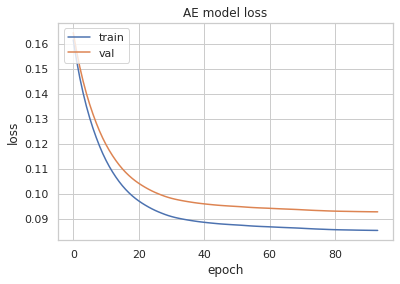

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_8 (Dense)              (None, 700)               700700    
Total params: 10,703,700
Trainable params: 10,703,700
Non-trainable params: 0
_________________________________________________________________
None

Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.98      0.24      0.39      1350
         1.0       0.57      1.00      0.72      1350

    accuracy                           0.62      2700
   macro avg       0.78      0.62      0.56      2700
weighted avg       0.78      0.62      0.56      2700


Acc

In [ ]:
Batchsize=32
epoch_num=500
#training
save_dir = '/content/drive/My Drive/.../'
autoencoder,latent=AE_model(x_scaled_train,encodding_dim)
autoencoder.compile(optimizer='adadelta', loss='mse')#specifying a loss, metrics, and an optimizer
print(autoencoder.summary())

#create call backs
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'modeltotalAE_raw.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=3,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
callbacks_list = [early_stop, checkpoint]## This saves the best model
# FIT THE MODEL
#--------------------------CNN autoencoder-------------------------
history=autoencoder.fit(x_scaled_train, x_scaled_train, 
                batch_size = Batchsize, epochs = epoch_num, 
                shuffle=True, validation_data = (x_scaled_val, x_scaled_val),verbose=1,callbacks=callbacks_list);
                #which will train the model by slicing the data into "batches" of size "batch_size", and repeatedly iterating over the entire dataset for a given number of "epochs".
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# LOAD BEST MODEL to evaluate the performance of the model
autoencoder.load_weights("/content/drive/My Drive/.../modeltotalAE_raw.h5")
#------find the new represenation of Train data
LatentRepresenation=extractrep(autoencoder)
print(LatentRepresenation.summary())

x_nondep_training_data=x_nondep_train.copy()
x_dep_training_data=x_dep_train.copy()

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_training_data)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_training_data)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels

x_nondep_validation_data=x_nondep_val.copy()
x_dep_validation_data=x_dep_val.copy()

Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_validation_data)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_validation_data)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid .shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))

cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())

tf.keras.backend.clear_session()


Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.99      0.10      0.18      1650
         1.0       0.53      1.00      0.69      1650

    accuracy                           0.55      3300
   macro avg       0.76      0.55      0.44      3300
weighted avg       0.76      0.55      0.44      3300


Accuracy Score:  0.55

[0.10060606 0.99939394]


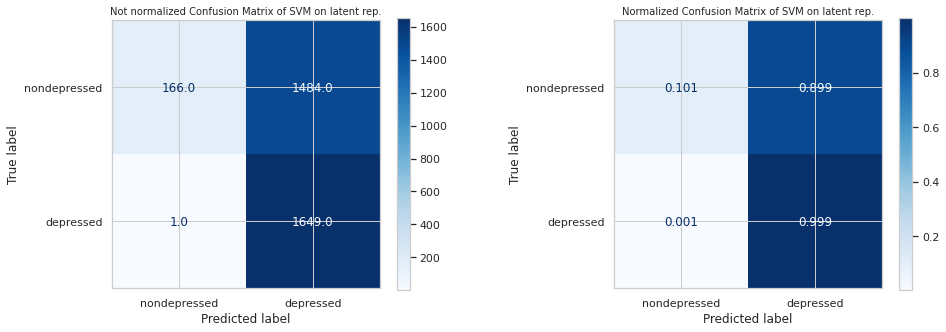

In [ ]:
#testing

whole_train_x=np.concatenate((x_scaled_train, x_scaled_val), axis=0)
whole_train_y=np.concatenate([y_train, y_val])
x_nondep_train, x_dep_train = whole_train_x[whole_train_y == 0], whole_train_x[whole_train_y == 1]
#------find the new represenation of Train and Dev data as new train data
LatentRepresenation=extractrep(autoencoder)

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_train)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_train)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels


Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_test)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_test)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid.shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#tsne_plot(rep_x_Train, rep_y_Train, "original data with SVM")
#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of SVM on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of SVM on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)

plt.show()

# checking saved model

In [ ]:
autoencoder,latent=AE_model(x_scaled_train,encodding_dim)
autoencoder.load_weights("/content/drive/My Drive/.../modeltotalAE_raw.h5")
print(autoencoder.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4000)]            0         
_________________________________________________________________
dense (Dense)                (None, 2000)              8002000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_2 (Dense)              (None, 700)               700700    
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              701000    
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              800400

In [ ]:
#testing

whole_train_x=np.concatenate((x_scaled_train, x_scaled_val), axis=0)
whole_train_y=np.concatenate([y_train, y_val])
x_nondep_train, x_dep_train = whole_train_x[whole_train_y == 0], whole_train_x[whole_train_y == 1]
#------find the new represenation of Train and Dev data as new train data
LatentRepresenation=extractrep(autoencoder)

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_train)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_train)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels


Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_test)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_test)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid.shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels


#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))

cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())



Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.99      0.10      0.18      1650
         1.0       0.53      1.00      0.69      1650

    accuracy                           0.55      3300
   macro avg       0.76      0.55      0.44      3300
weighted avg       0.76      0.55      0.44      3300


Accuracy Score:  0.55

[0.10060606 0.99939394]



Classification Report: Mlp  on latent
              precision    recall  f1-score   support

         0.0       0.64      0.84      0.73      1650
         1.0       0.77      0.52      0.62      1650

    accuracy                           0.68      3300
   macro avg       0.71      0.68      0.68      3300
weighted avg       0.71      0.68      0.68      3300


Accuracy Score:  0.6842424242424242

[0.84424242 0.52424242]


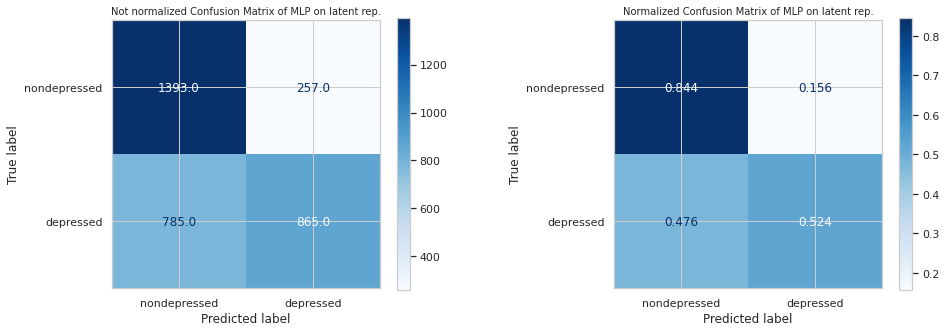

In [ ]:
#-------------------------------evaluate model
#  MLP classifier on trained latent space
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1,hidden_layer_sizes=(128,100,),activation='logistic', max_iter=100).fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: Mlp  on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of MLP on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of MLP on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
plt.show()